In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


 # Ver 4



Mulai Training 'Ultimate Hybrid'...
  Memproses apel_malang...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17480\1396999157.py:159: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=90, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0),


  Memproses jambu_guava...
  Memproses jeruk_bali...
  Memproses mangga...
  Memproses melon...
Total Data Latih: 3052
Melatih SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Model Tersimpan!

=== VISUALISASI HASIL & FITUR ===


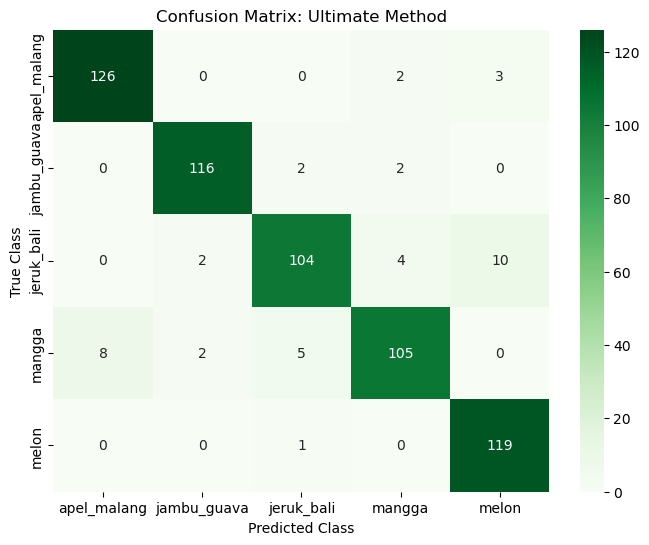

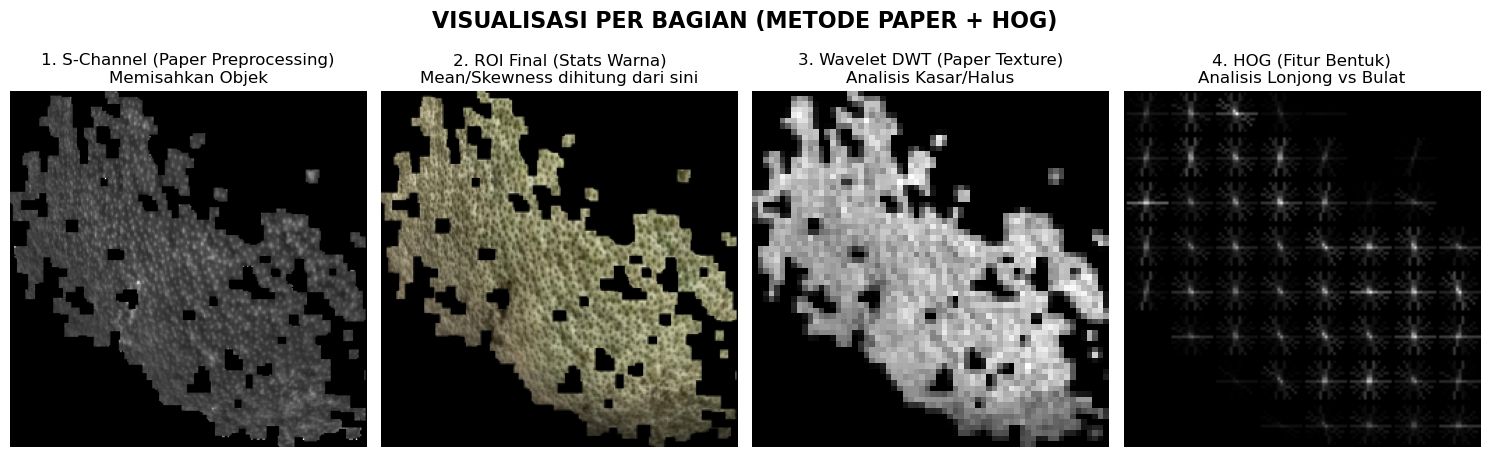

In [2]:
# ==================================================================================
# PIPELINE
# ==================================================================================

import cv2
import numpy as np
import os
import glob
import pywt
import joblib
import albumentations as A
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops, hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# 1. KONFIGURASI
base_path = "dataset"
class_names = ['apel_malang', 'jambu_guava', 'jeruk_bali', 'mangga', 'melon']
class_to_id = {name: idx for idx, name in enumerate(class_names)}

# ==========================================
# A. PREPROCESSING
# ==========================================

def apply_clahe(image):
    """Meningkatkan kontras lokal agar tekstur pori-pori terlihat jelas."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def resize_with_padding(image, target_size=(256, 256)):
    """Resize dengan padding hitam (Letterbox) agar rasio bentuk terjaga."""
    h, w = image.shape[:2]
    target_w, target_h = target_size
    scale = min(target_w/w, target_h/h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    x_offset, y_offset = (target_w - new_w) // 2, (target_h - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas

def preprocess_image(image):
    """
    Kombinasi Metode Paper (S-Channel Thresholding)
    dengan CLAHE dan Strict Masking.
    """
    # 1. Enhance Texture
    image = apply_clahe(image)

    # 2. Convert HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 3. Strict Masking (Hanya Hijau & Kuning Buah)
    lower = np.array([20, 50, 40])
    upper = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    # 4. Clean Noise
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 5. Crop ROI
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest_contour) > 1000:
            x, y, w, h_rect = cv2.boundingRect(largest_contour)
            roi = image[y:y+h_rect, x:x+w]
            mask_roi = mask[y:y+h_rect, x:x+w]
            roi = cv2.bitwise_and(roi, roi, mask=mask_roi) # Background Hitam Pekat
            return resize_with_padding(roi, (256, 256))

    return resize_with_padding(image, (256, 256))

# ==========================================
# B. FEATURE EXTRACTION
# ==========================================

def get_color_stats(image):
    """Fitur Paper: Statistik H & S (Mean, Std, Skew, Kurt) [cite: 103]"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, _ = cv2.split(hsv)
    features = []
    for channel in [h, s]:
        features.extend([np.mean(channel), np.std(channel), skew(channel.flatten()), kurtosis(channel.flatten())])
    return np.array(features)

def get_texture_features(image):
    """Fitur Paper: Wavelet DWT Level 3 + GLCM """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    _, _, v = cv2.split(hsv)

    # Wavelet
    coeffs = pywt.wavedec2(v, 'haar', level=3)

    # GLCM
    LL1 = pywt.wavedec2(v, 'haar', level=1)[0]
    LL1_norm = cv2.normalize(LL1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    glcm = graycomatrix(LL1_norm, distances=[1, 3], angles=[0, np.pi/4, np.pi/2], levels=256, symmetric=True, normed=True)

    # Fitur GLCM Standard
    contrast = graycoprops(glcm, 'contrast').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()

    # Fitur GLCM Lanjutan (Cluster Shade & Prominence)
    shades, prominences = [], []
    for i in range(glcm.shape[2]):
        for j in range(glcm.shape[3]):
            matrix = glcm[:, :, i, j]
            N = matrix.shape[0]
            r, c = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
            mean_i, mean_j = np.sum(r * matrix), np.sum(c * matrix)
            term = (r + c - mean_i - mean_j)
            shades.append(np.sum((term ** 3) * matrix))
            prominences.append(np.sum((term ** 4) * matrix))

    # Std Dev Wavelet Details
    wavelet_std = [np.std(coeffs[0])]
    for level in coeffs[1:]:
        wavelet_std.extend([np.std(c) for c in level])

    return np.array([contrast, energy, homogeneity, np.mean(shades), np.mean(prominences)] + wavelet_std)

def get_hog_features(image):
    """Fitur Tambahan: HOG untuk Bentuk (Mangga vs Guava)"""
    img_resized = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    fd = hog(gray, orientations=9, pixels_per_cell=(16, 16),
             cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')
    return fd

def extract_features_ultimate(image):
    roi = preprocess_image(image)
    return np.hstack([
        get_color_stats(roi),
        get_texture_features(roi),
        get_hog_features(roi)
    ])

# ==========================================
# C. TRAINING AUGMENTASI & SVM
# ==========================================

def setup_augmentations():
    return A.Compose([
        A.Rotate(limit=90, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5)
    ])

print("\nMulai Training 'Ultimate Hybrid'...")
X, y = [], []
augmentor = setup_augmentations()
N_AUGMENTATIONS = 3

for class_name in class_names:
    folder = os.path.join(base_path, class_name)
    if not os.path.exists(folder): continue

    img_paths = glob.glob(os.path.join(folder, "*"))
    print(f"  Memproses {class_name}...")

    for path in img_paths:
        img = cv2.imread(path)
        if img is None: continue

        # Original
        feats = extract_features_ultimate(img)
        if np.any(np.isnan(feats)): feats = np.nan_to_num(feats)
        X.append(feats); y.append(class_to_id[class_name])

        # Augmentasi
        for _ in range(N_AUGMENTATIONS):
            aug = augmentor(image=img)['image']
            feats_aug = extract_features_ultimate(aug)
            if np.any(np.isnan(feats_aug)): feats_aug = np.nan_to_num(feats_aug)
            X.append(feats_aug); y.append(class_to_id[class_name])

X = np.array(X)
y = np.array(y)
print(f"Total Data Latih: {len(X)}")

# Normalisasi & Split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# SVM Training
print("Melatih SVM...")
grid = GridSearchCV(
    SVC(probability=True),   # <==== DITAMBAHKAN
    {
        'C': [1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    },
    cv=3,
    verbose=1,
    n_jobs=1
)
grid.fit(X_train, y_train)
best_svm = grid.best_estimator_


# Save
joblib.dump(best_svm, os.path.join(base_path, 'model_svm_ultimate.pkl'))
joblib.dump(scaler, os.path.join(base_path, 'scaler_ultimate.pkl'))
print("Model Tersimpan!")

# ==========================================
# D. VISUALISASI
# ==========================================

print("\n=== VISUALISASI HASIL & FITUR ===")

# 1. Confusion Matrix
y_pred = best_svm.predict(X_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Ultimate Method')
plt.ylabel('True Class'); plt.xlabel('Predicted Class')
plt.show()

# 2. Visualisasi Per Bagian (Warna, Tekstur, Bentuk)
import random
sample_path = random.choice(glob.glob(os.path.join(base_path, "*", "*.jpg")))
img_sample = cv2.imread(sample_path)
roi_sample = preprocess_image(img_sample)

plt.figure(figsize=(15, 5))
plt.suptitle("VISUALISASI PER BAGIAN (METODE PAPER + HOG)", fontsize=16, fontweight='bold')

# Bagian 1: Preprocessing (S-Channel)
plt.subplot(1, 4, 1)
hsv = cv2.cvtColor(roi_sample, cv2.COLOR_BGR2HSV)
plt.imshow(hsv[:,:,1], cmap='gray')
plt.title("1. S-Channel (Paper Preprocessing)\nMemisahkan Objek")
plt.axis('off')

# Bagian 2: Warna (Stats)
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(roi_sample, cv2.COLOR_BGR2RGB))
plt.title("2. ROI Final (Stats Warna)\nMean/Skewness dihitung dari sini")
plt.axis('off')

# Bagian 3: Tekstur (Wavelet)
_, _, v = cv2.split(hsv)
coeffs = pywt.wavedec2(v, 'haar', level=2)
plt.subplot(1, 4, 3)
plt.imshow(coeffs[0], cmap='gray')
plt.title("3. Wavelet DWT (Paper Texture)\nAnalisis Kasar/Halus")
plt.axis('off')

# Bagian 4: Bentuk (HOG)
img_resized = cv2.resize(roi_sample, (128, 128))
_, hog_viz = hog(cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY), orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
plt.subplot(1, 4, 4)
plt.imshow(hog_viz, cmap='gray')
plt.title("4. HOG (Fitur Bentuk)\nAnalisis Lonjong vs Bulat")
plt.axis('off')

plt.tight_layout()
plt.show()

🔄 Memuat Model...
 Model & Scaler Siap!

   SISTEM DETEKSI BUAH ULTIMATE - MODE UPLOAD LOKAL
   (Tanpa Kamera, Tanpa Colab)

📂 Pilih gambar buah dari komputer Anda...
Memuat file: C:/Users/ASUS/Downloads/apel-malang.jpg


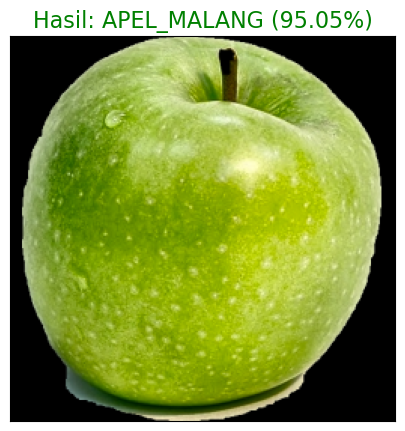

🎯 HASIL DETEKSI: APEL_MALANG | Akurasi: 95.05%


In [1]:
# ====================================================================
# DETEKSI BUAH: MODE UPLOAD LOKAL (TANPA KAMERA, TANPA COLAB)
# ====================================================================

import cv2
import numpy as np
import joblib
import pywt
import os
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops, hog
import matplotlib.pyplot as plt
from PIL import Image
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# ================================
# 1. LOAD MODEL
# ================================
base_path = "dataset"
class_names = ['apel_malang', 'jambu_guava', 'jeruk_bali', 'mangga', 'melon']

print("🔄 Memuat Model...")
try:
    svm_model = joblib.load(os.path.join(base_path, 'model_svm_ultimate.pkl'))
    scaler = joblib.load(os.path.join(base_path, 'scaler_ultimate.pkl'))
    print(" Model & Scaler Siap!")
except:
    print("❌ Error: File model tidak ditemukan. Pastikan sudah training.")
    raise SystemExit()

# ================================
# 2. PREPROCESSING (SAMA)
# ================================
def resize_with_padding(image, target_size=(256, 256)):
    h, w = image.shape[:2]
    target_w, target_h = target_size
    scale = min(target_w/w, target_h/h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    x_offset, y_offset = (target_w - new_w) // 2, (target_h - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas

def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def preprocess_image(image):
    image = apply_clahe(image)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower = np.array([20, 50, 40])
    upper = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest) > 1000:
            x, y, w, h = cv2.boundingRect(largest)
            roi = image[y:y+h, x:x+w]
            mask_roi = mask[y:y+h, x:x+w]
            roi = cv2.bitwise_and(roi, roi, mask=mask_roi)
            return resize_with_padding(roi, (256, 256))

    return resize_with_padding(image, (256, 256))

# ================================
# 3. EKSTRAKSI & PREDIKSI (SAMA)
# ================================
def extract_features_ultimate_lite(image):
    roi = preprocess_image(image)

    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    h, s, _ = cv2.split(hsv)

    color_feats = []
    for channel in [h, s]:
        color_feats.extend([np.mean(channel), np.std(channel),
                            skew(channel.flatten()), kurtosis(channel.flatten())])

    _, _, v = cv2.split(hsv)
    coeffs = pywt.wavedec2(v, 'haar', level=3)
    LL1 = pywt.wavedec2(v, 'haar', level=1)[0]
    LL1_norm = cv2.normalize(LL1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    glcm = graycomatrix(LL1_norm, distances=[1,3], angles=[0,np.pi/4,np.pi/2], levels=256,
                        symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()

    shades = []
    prominences = []
    for i in range(glcm.shape[2]):
        for j in range(glcm.shape[3]):
            m = glcm[:, :, i, j]
            N = m.shape[0]
            r, c = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
            mean_i = np.sum(r * m)
            mean_j = np.sum(c * m)
            term = (r + c - mean_i - mean_j)
            shades.append(np.sum((term ** 3) * m))
            prominences.append(np.sum((term ** 4) * m))

    wavelet_std = [np.std(coeffs[0])]
    for level in coeffs[1:]:
        wavelet_std.extend([np.std(c) for c in level])

    img_resized = cv2.resize(roi, (128, 128))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    hog_feats = hog(gray, orientations=9, pixels_per_cell=(16,16),
                    cells_per_block=(2,2), visualize=False, block_norm='L2-Hys')

    return np.hstack([
        color_feats,
        [contrast, energy, homogeneity, np.mean(shades), np.mean(prominences)],
        wavelet_std,
        hog_feats
    ]), roi

def predict_and_visualize(image):
    raw_feats, roi = extract_features_ultimate_lite(image)
    raw_feats = np.nan_to_num(raw_feats)
    scaled = scaler.transform(raw_feats.reshape(1, -1))

    # Prediksi index kelas
    pred_idx = svm_model.predict(scaled)[0]
    pred_class = class_names[pred_idx]

    # Prediksi probabilitas akurasi (jika model dilatih dengan probability=True)
    try:
        proba = svm_model.predict_proba(scaled)[0]   # Ambil array probabilitas per kelas
        confidence = proba[pred_idx] * 100           # Ambil probabilitas kelas terprediksi
    except:
        confidence = None

    # Tampilkan gambar + label + akurasi
    plt.figure(figsize=(6,5))
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    
    if confidence is not None:
        title_text = f"Hasil: {pred_class.upper()} ({confidence:.2f}%)"
    else:
        title_text = f"Hasil: {pred_class.upper()} (No probability)"
        
    plt.title(title_text, fontsize=16, color='green')
    plt.xticks([]); plt.yticks([])
    plt.show()

    # Print ke terminal
    if confidence is not None:
        print(f"🎯 HASIL DETEKSI: {pred_class.upper()} | Akurasi: {confidence:.2f}%")
    else:
        print(f"🎯 HASIL DETEKSI: {pred_class.upper()} (Tanpa probability)")



# ================================
# 4. MODE UPLOAD FILE
# ================================
def run_upload_mode():
    print("\n📂 Pilih gambar buah dari komputer Anda...")

    # File picker
    Tk().withdraw()
    filepath = askopenfilename(
        filetypes=[("Image Files", "*.jpg *.jpeg *.png"), ("All files", "*.*")]
    )

    if not filepath:
        print("❌ Tidak ada file dipilih.")
        return

    print(f"Memuat file: {filepath}")
    img = cv2.imread(filepath)

    if img is None:
        print("❌ Gambar tidak bisa dibaca.")
        return

    predict_and_visualize(img)

# ================================
# 5. JALANKAN
# ================================
print("\n========================================")
print("   SISTEM DETEKSI BUAH ULTIMATE - MODE UPLOAD LOKAL")
print("   (Tanpa Kamera, Tanpa Colab)")
print("========================================")

run_upload_mode()
